In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [52]:
# read data
df = pd.read_csv("../input/digit-recognizer/train.csv")

data = df.to_numpy()
np.random.shuffle(data)

X_train = data[:,1:].T / 255
# do we need to normalize data to [0,1) ? 
y_train = data[:,0]

m, n = data.shape

index:  0  label:  1
index:  1  label:  0
index:  2  label:  1
index:  3  label:  4
index:  4  label:  0
index:  5  label:  0
index:  6  label:  7
index:  7  label:  3
index:  8  label:  5


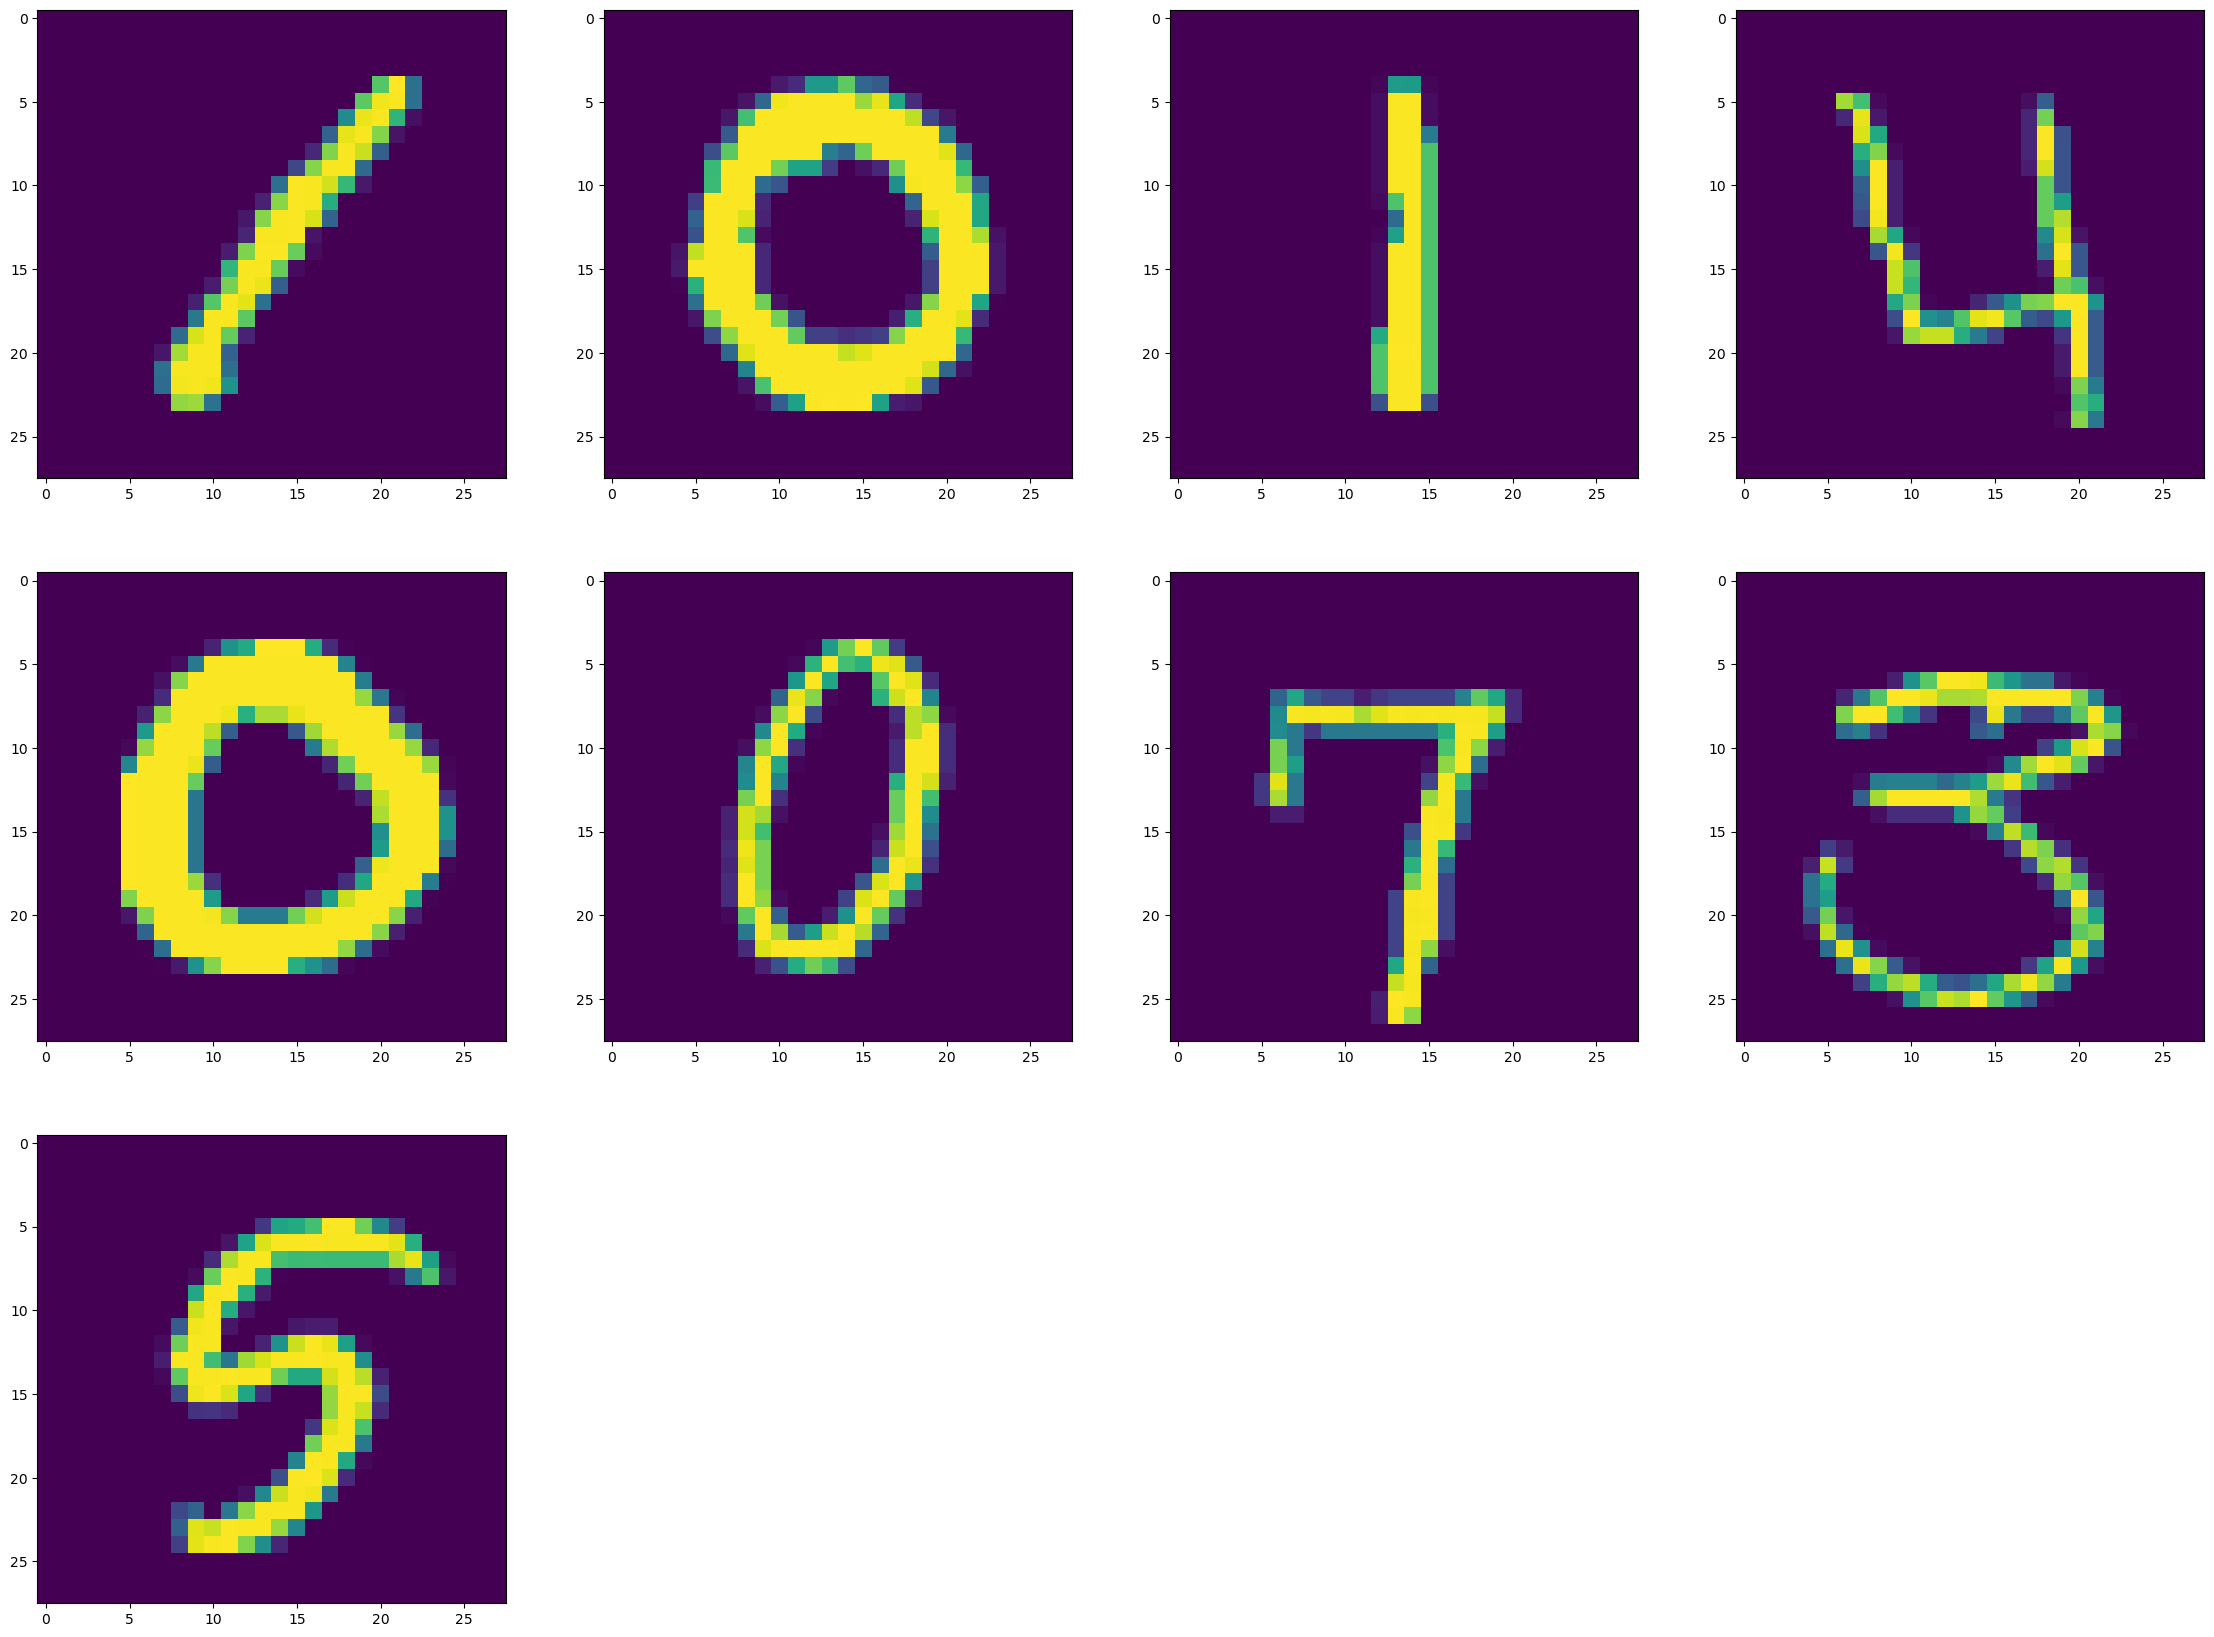

In [22]:
# Define some helper methods for displaying
def show_image(row):
    plt.imshow(X_train[:,row].reshape(28,28))
    print("index: ", row, " label: ", y_train[row])
    # print("label: ", Y_train[row])

fig = plt.figure(figsize=(28,28))
for i in range(1,10):
    fig.add_subplot(4,4,i)
    show_image(i-1)

plt.show()
    


In [33]:
y_train[:10]

array([3, 4, 7, 2, 5, 6, 5, 0, 6, 4])

```
# Define methods for neural network
# 
# Initialize matrices
#   W1, b1, W2, b2
#
# Forward propagation algorithm:
#   Where M = # pixels
#   Where N = # samples
# Layer 0:
#   X1 (M x N): initial training data
#               M: pixels (feature)
#               N: number of samples
#   W1 (M x K): initial weights.
#               K: a hyperparameter specifying the number of hidden units in the
#               first hidden layer. This is a design choice. Recommended to start conservative, and grad.
#               increase complexity as needed
#   b1 (K x 1): initial biases
#               But this needs to be broadcast across each column. W1.T.dot(X1) = a matrix of (K x N),
#               which cannot be directly added to b1. So for each column N, broadcast b1 to it.
# Layer 1: Activation layer 1
#   h (K x N) = g(W1.T . X1 + b1)
#   g = ReLU()
# Layer 2: Output Layer
#   W2: constrain to answers
#   b2: biases
#   y = softmax(W2 . A1 + b2)
#   y is a matrix of 10 x N, where each row represents probability distribution of most likely digit
#   softmax = e ** Zi / sum(j=1,K) e ** Zj
#       softmax converts vector of K real numbers into probability distribution of K possible outcomes
#   
# Backward propagation algorithm:
#   # use a distance formula 

# training algorithm (gradient_descent)
# 1) while iterations < total:
#   1) forward propagation
#   2) backward propagate
#   3) adjust weights and biases
# 2) training complete
#   1) can use model to predict number
```

In [70]:
# def init_params(M, K): 
#     W1 = np.random.rand(K,M) - 0.5
#     b1 = np.random.rand(K,1) - 0.5
#     W2 = np.random.rand(10,K) - 0.5
#     b2 = np.random.rand(10,1) - 0.5
#     return W1, b1, W2, b2

# use Xavier/Glorot initialization for hidden layers
def init_params(M, K): 
    W1 = np.random.randn(K, M) * np.sqrt(2 / (M + K))
    b1 = np.random.randn(K, 1) * np.sqrt(2 / (M + K))
    W2 = np.random.randn(10, K) * np.sqrt(2 / (10 + K))
    b2 = np.random.randn(10, 1) * np.sqrt(2 / (10 + K))
    return W1, b1, W2, b2

def ReLU(X):
    return np.maximum(X,0)

def deriv_ReLU(X):
    return X > 0

def forward_propagate_l1(W1, b1, X):
    z = W1.dot(X) + b1
    h = ReLU(z)
    return h, z

# my implementation of softmax very slow
# def softmax(X):
#     for j in range(X.shape[1]): # 10 x 42000
#         shifted = X[:,j] - np.max(X[:,j]) # shift to avoid overflow errors from high e^x
#         sum = np.sum(np.exp(shifted))
#         for i in range(X.shape[0]): # 10
#             X[i,j] = np.exp(shifted[i]) / sum
#     return X

def softmax(X):
    exp_X = np.exp(X - np.max(X, axis=0, keepdims=True))
    return exp_X / np.sum(exp_X, axis=0, keepdims=True)


def output_layer(W2, b2, h):
    y = softmax(W2.dot(h) + b2)
    return y

def one_hot_encode(y_train):
    y = np.zeros((10,len(y_train)))
    for i in range(len(y_train)):
        y[y_train[i],i] = 1
    return y

def mean_square_loss(y, t):
    # Method 1: perhaps take the highest probability index in one col, one-hot encode that
    # then subtract against OHE y array, this will be 1 or -1 error for each row.
    # Method 2: instead, just subtract all values from OHE y array, square it and this
    # becomes the MSE. Higher percentage certainty means less loss. 
    mse = np.sum(np.square(y - t))
    return mse

def backprop(W2, y, h, X_train, t, z):
    dy = y - t # get loss                         # (10,N)
    dw2 = 1/m * dy.dot(h.T)                       # (K,10)    
    db2 = 1/m * dy.sum(axis=1, keepdims=True)     # (K,1)
    dh = W2.T.dot(dy)                             # (K,N)
    dz = dh * deriv_ReLU(z)                       # (K,N)
    dw1 = 1/m * dz.dot(X_train.T)                 # (M,K)
    db1 = 1/m * dz.sum(axis=1, keepdims=True)     # (K,1)
    return dw1, db1, dw2, db2

def get_predictions(y):
    return np.argmax(y, 0)

def get_accuracy(predictions, y_train):
    print(predictions, y_train)
    return np.sum(predictions == y_train) / y_train.size

# train the model, return weights
def train(X_train, y_train, alpha, iterations):
    print("Beginning model training with alpha ", alpha, " and ", iterations, " iterations.")
    M, N = X_train.shape[0], X_train.shape[1]
    W1, b1, W2, b2 = init_params(M,K)
    t = one_hot_encode(y_train)
    for i in range(iterations):
        h, z1 = forward_propagate_l1(W1, b1, X_train)
        y = output_layer(W2, b2, h)
        dw1, db1, dw2, db2 = backprop(W2, y, h, X_train, t, z1)
        
        # recompute the weights 
        W1 = W1 - alpha * dw1
        b1 = b1 - alpha * db1
        W2 = W2 - alpha * dw2
        b2 = b2 - alpha * db2
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Loss: ", mean_square_loss(y, t))
            print("Accuracy:", get_accuracy(get_predictions(y), y_train))

    return W1, b1, W2, b2

# Select hyperparameters
alpha = 0.1    # learning rate
K = 10         # number of hidden nodes in hidden layer 

# train model
W1, b1, W2, b2 = train(X_train, y_train, alpha, 500)


Beginning model training with alpha  0.1  and  500  iterations.
Iteration:  0
Loss:  38320.399099771435
[7 8 9 ... 9 9 9] [5 9 1 ... 0 1 0]
Accuracy: 0.049833333333333334
Iteration:  10
Loss:  36291.025384348155
[7 2 1 ... 6 1 9] [5 9 1 ... 0 1 0]
Accuracy: 0.3011666666666667
Iteration:  20
Loss:  33148.665684464235
[6 5 1 ... 6 1 6] [5 9 1 ... 0 1 0]
Accuracy: 0.43597619047619046
Iteration:  30
Loss:  29627.0962169427
[5 5 1 ... 0 1 0] [5 9 1 ... 0 1 0]
Accuracy: 0.5613809523809524


KeyboardInterrupt: 